<a href="https://colab.research.google.com/github/maharani032/sentimen/blob/main/analisis_sentimen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sastrawi
!pip install preprocessor

In [217]:
import pandas as pd
import preprocessor as p
from textblob import TextBlob
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [76]:
data = pd.read_excel("/content/drive/MyDrive/Skripsi/Database baru/Data tweet CHATGPT dan label v2.xlsx")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      1030 non-null   object
 1   username  1030 non-null   object
 2   tweet     1030 non-null   object
 3   label     1030 non-null   object
dtypes: object(4)
memory usage: 32.3+ KB


In [77]:
# remove mention
def remove_mention(tweet,pattern_regex):
    r=re.findall(pattern_regex,tweet)
    for i in r:
        tweet=re.sub(i,"",tweet)
    return tweet

In [78]:
data['remove_mention']=np.vectorize(remove_mention)(data['tweet']," *RT* | *@[\w]*")
data.head()

,date,username,tweet,label,remove_mention
0,2023-02-09 15:17:56,faridisasii,@gilraldy pembimbing gua chatgpt sekarang,netral,pembimbing gua chatgpt sekarang
1,2023-03-16 09:33:49,ryenapha,Turnitin udah bisa ngecek chatgpt ðŸ˜­,netral,Turnitin udah bisa ngecek chatgpt ðŸ˜­
2,2023-03-16 09:12:04,ShiHuangg,Untung aja matkul matkul lain masih bisa ngerj...,positif,Untung aja matkul matkul lain masih bisa ngerj...
3,2023-03-16 09:11:27,akuuu_nindy,"Hampir gila, tapi untung ada chatGPT. terimaka...",positif,"Hampir gila, tapi untung ada chatGPT. terimaka..."
4,2023-03-16 09:10:11,ShiHuangg,"Sama kalo bisa bangun rumah dari sekarang, ana...",netral,"Sama kalo bisa bangun rumah dari sekarang, ana..."


In [81]:
def remove_http(tweet):
    tweet=" ".join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",tweet).split())
    return tweet
data['remove_http']=data['remove_mention'].apply(lambda x:remove_http(x))
data.head(5)

,date,username,tweet,label,remove_mention,remove_http
0,2023-02-09 15:17:56,faridisasii,@gilraldy pembimbing gua chatgpt sekarang,netral,pembimbing gua chatgpt sekarang,pembimbing gua chatgpt sekarang
1,2023-03-16 09:33:49,ryenapha,Turnitin udah bisa ngecek chatgpt ðŸ˜­,netral,Turnitin udah bisa ngecek chatgpt ðŸ˜­,Turnitin udah bisa ngecek chatgpt
2,2023-03-16 09:12:04,ShiHuangg,Untung aja matkul matkul lain masih bisa ngerj...,positif,Untung aja matkul matkul lain masih bisa ngerj...,Untung aja matkul matkul lain masih bisa ngerj...
3,2023-03-16 09:11:27,akuuu_nindy,"Hampir gila, tapi untung ada chatGPT. terimaka...",positif,"Hampir gila, tapi untung ada chatGPT. terimaka...",Hampir gila tapi untung ada chatGPT terimakasi...
4,2023-03-16 09:10:11,ShiHuangg,"Sama kalo bisa bangun rumah dari sekarang, ana...",netral,"Sama kalo bisa bangun rumah dari sekarang, ana...",Sama kalo bisa bangun rumah dari sekarang anak...


In [82]:
def removeHastag(tweet):
#     hastag dolar sign
    tweet=re.sub(r'\$\w*','',tweet)
#     retweet lama
    tweet=re.sub(r'^RT[\s]+','',tweet)
#     hastag
    tweet=re.sub(r'#', '',tweet)
#     hapus angka
    tweet=re.sub('[0-9]+','',tweet)
    return tweet

In [ ]:
data['remove_hastag']=data['remove_http'].apply(lambda x:removeHastag(x))
data.head(5)

In [84]:
data.drop_duplicates(subset='remove_hastag',keep='first',inplace=True)
data.head(5)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1024 entries, 0 to 1029
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   date            1024 non-null   object
 1   username        1024 non-null   object
 2   tweet           1024 non-null   object
 3   label           1024 non-null   object
 4   remove_mention  1024 non-null   object
 5   remove_http     1024 non-null   object
 6   remove_hastag   1024 non-null   object
dtypes: object(7)
memory usage: 64.0+ KB


In [ ]:
def case_folding(tweet):
    return tweet.casefold()
data['case_folding']=data['remove_hastag'].apply(lambda x:case_folding(x))
data.head(5)

In [86]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stopwords_indonesia=stopwords.words('indonesian')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [88]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory,StopWordRemover,ArrayDictionary
stop_factory = StopWordRemoverFactory().get_stop_words()
stopwords_indonesia=stopwords.words('indonesian')

In [155]:
more_stopword = [
    'yg','dgn','kan','huh','bruh','xd','xf','hahaha','nya','wkwkwkkwkwk','akwkaskaksawska','wkwkw','wkwkkwwkk'
    'kok','kyk','dong','donk','yah','tuh','si','siii','wkwk','wkwkwk','ini','tp','utk','sj','pd','gw','gua','gwe',
    'wow','wowwwwwah','icymi','ni','coy','coii','isenkisenk','dg','pdhl','aja','tadi','krn','tak',
    'aja','sbb','kuy','se','skrg','yep','aja','as','yaa','jadinya','aja','coba','tibatiba','shit','knp','jdi','dmn','kyk'
    'sih','bang','oke','nah','bgt','km','ttg','dlm','aaa','kang','hehe','wes','you','doang','wkkw','ong','sm','he','yeee'
    ,'emg','kak','gan','woy','dm','hi','kakk','min','di','noh','gais','lah','xfxf','nak','bro','x','ahhh','gasss','hmmm','sat','set','yukkkkk'
    ,'smh','eh','ni','laaah',' aihihi','fafifu','akwkaskaksawska ','xixi','kah','tbtb','bg','jg','pas','w','jga','cm','hiks','mennn','sii','sy','aku',
    ]

In [156]:
stopword=stop_factory+more_stopword+stopwords_indonesia
dictionary=ArrayDictionary(stopword)
str=StopWordRemover(dictionary)
print(stopword)

['yang', 'untuk', 'pada', 'ke', 'para', 'namun', 'menurut', 'antara', 'dia', 'dua', 'ia', 'seperti', 'jika', 'jika', 'sehingga', 'kembali', 'dan', 'tidak', 'ini', 'karena', 'kepada', 'oleh', 'saat', 'harus', 'sementara', 'setelah', 'belum', 'kami', 'sekitar', 'bagi', 'serta', 'di', 'dari', 'telah', 'sebagai', 'masih', 'hal', 'ketika', 'adalah', 'itu', 'dalam', 'bisa', 'bahwa', 'atau', 'hanya', 'kita', 'dengan', 'akan', 'juga', 'ada', 'mereka', 'sudah', 'saya', 'terhadap', 'secara', 'agar', 'lain', 'anda', 'begitu', 'mengapa', 'kenapa', 'yaitu', 'yakni', 'daripada', 'itulah', 'lagi', 'maka', 'tentang', 'demi', 'dimana', 'kemana', 'pula', 'sambil', 'sebelum', 'sesudah', 'supaya', 'guna', 'kah', 'pun', 'sampai', 'sedangkan', 'selagi', 'sementara', 'tetapi', 'apakah', 'kecuali', 'sebab', 'selain', 'seolah', 'seraya', 'seterusnya', 'tanpa', 'agak', 'boleh', 'dapat', 'dsb', 'dst', 'dll', 'dahulu', 'dulunya', 'anu', 'demikian', 'tapi', 'ingin', 'juga', 'nggak', 'mari', 'nanti', 'melainkan', '

In [94]:
# import sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
# import tokenize
from nltk.tokenize import TweetTokenizer

In [96]:
factory=StemmerFactory()
stemmer=factory.create_stemmer()

In [97]:
def clean_tweets(tweet):
#     tokenize tweets
    tokenizer=TweetTokenizer(preserve_case=False,strip_handles=True,reduce_len=True)
    tweet_token=tokenizer.tokenize(tweet)
    
    tweet_clean=[]
    for word in tweet_token:
        if(word not in stopword):
            stem_word=stemmer.stem(word)
            tweet_clean.append(stem_word)
    return tweet_clean

In [ ]:
data['clean_tweet']=data['case_folding'].apply(lambda x:clean_tweets(x))
data.head(5)
#  filename = '18-04-2023.csv'
#     db_tweets.to_csv('/content/drive/MyDrive/Skripsi/Database baru/'+filename, index=False)


In [ ]:
def tweet(tweet):
    return " ".join(tweet)
data['clean tweet']=data['clean_tweet'].apply(lambda x:tweet(x))
data.head(5)

In [ ]:
newData=pd.DataFrame()
newData['date']=data['date']
newData['username']=data['username']
newData['tweet']=data['tweet']
newData['clean tweet']=data['clean tweet']
newData['label']=data['label']
filename='processing-lengkap.xlsx'
newFilename='preprocessing-sudah.xlsx'
data.to_excel('/content/drive/MyDrive/Skripsi/Database baru/'+filename, index=False, encoding='utf-8')
newData.to_excel('/content/drive/MyDrive/Skripsi/Database baru/'+newFilename, index=False, encoding='utf-8')

In [ ]:
# newData= pd.read_excel("/content/drive/MyDrive/Skripsi/Database baru/preprocessing-sudah.xlsx")
# newData.info()

In [ ]:
#  # hitung term frequency (tf) dari data teks
bow_transformer = CountVectorizer().fit(newData['clean tweet'])
# np.set_printoptions(threshold=np.inf, linewidth=np.inf)
bow_transformer.vocabulary_ #


In [110]:
tokens = bow_transformer.get_feature_names_out()
# print(tokens) 

In [111]:
text_bow = bow_transformer.transform(newData['clean tweet'])
# print(text_bow)

In [ ]:
# # Mendapatkan matriks hasil transformasi
# df = pd.DataFrame(text_bow.toarray(), columns=tokens)

# # # Menghitung jumlah kemunculan term pada dokumen
# jumlah_kemunculan_term = df.sum()

# # # Menampilkan hasil
# print(jumlah_kemunculan_term.to_string())

In [ ]:
# mencari kata dalam data
# Mengubah list `terms` menjadi array NumPy
terms_array = np.array(tokens)

# Mendapatkan index dari term "bimbing" dalam array `terms_array`
term_index = np.where(terms_array == "bimbing")[0][0]

# Menghitung df dari term "bimbing"
df_data = sum([1 for doc in text_bow.toarray() if doc[term_index] > 0])
print("df dari term 'bimbing' adalah", df_data)

newData.head(4)
newData.info()

In [176]:
tfidf_transformer = TfidfTransformer()
tfidf = tfidf_transformer.fit_transform(text_bow)

In [177]:
corpus = newData['clean tweet'].tolist()

for doc_index in range(1): #len(corpus)
    print("TF-IDF dari dokumen ke-", doc_index+1)
    feature_index = tfidf[doc_index,:].nonzero()[1]
    tfidf_scores = zip(feature_index, [tfidf[doc_index, x] for x in feature_index])
    for term, score in [(tokens[i], score) for (i, score) in tfidf_scores]:
        print("{}: {}".format(term, score))
    print("\n")

TF-IDF dari dokumen ke- 1
chatgpt: 0.1566576517929201
bimbing: 0.987652965436103




In [ ]:
tfidf_df = pd.DataFrame(tfidf.toarray(), columns=tokens)
print(tfidf_df)

# newFilename='preprocessing-sudah.xlsx'
# data.to_excel('/content/drive/MyDrive/Skripsi/Database baru/'+filename, index=False, encoding='utf-8')
tfidf_df.to_excel('tf-idf.xlsx')

In [126]:
X = text_bow.toarray()
Y=newData['label']

In [226]:
# K-Fold Cross Validation dengan 10 fold
kfold = KFold(n_splits=3, shuffle=True, random_state=1)


In [227]:
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.2, random_state=35)
# train model Naive Bayes
model = MultinomialNB().fit(x_train,y_train)
# menggunakan kfold
scores = cross_val_score(model, x_train, y_train, cv=kfold,scoring='accuracy')

model.fit(x_train, y_train)
y_pred = nb.predict(x_train)
# print('Accuracy: %.3f%% (%.3f)' % (np.mean(scores)*100, np.std(scores)))


Akurasi: 0.6048780487804878
Presisi: 0.5442115984352748
Recall: 0.6048780487804878
F1-score: 0.5609812413682136


              precision    recall  f1-score   support

     negatif       0.65      0.61      0.63        70
      netral       0.19      0.07      0.10        44
     positif       0.63      0.86      0.73        91

    accuracy                           0.60       205
   macro avg       0.49      0.51      0.49       205
weighted avg       0.54      0.60      0.56       205

accuracy:   0.605


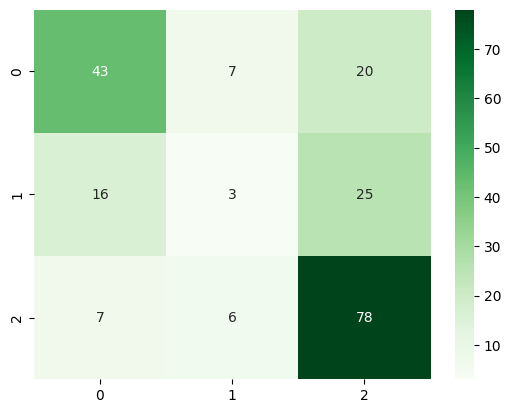

In [229]:
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.2, random_state=35)
# train model Naive Bayes
model = MultinomialNB().fit(x_train,y_train)
# menggunakan kfold
scores = cross_val_score(model, x_train, y_train, cv=kfold,scoring='accuracy')
# membuat prediksi untuk data train dan data test
train_prediction = model.predict(x_train)
test_prediction = model.predict(x_test)
nbc_report=classification_report(y_test,test_prediction)
print(nbc_report)

score1 = metrics.accuracy_score(y_test, test_prediction)

print('Accuracy: %.3f%% (%.3f)' % (np.mean(scores)*100, np.std(scores)))
print("accuracy:   %0.3f" % score1)
columns = ['negatif','netral','positif']
confm = confusion_matrix(y_test, test_prediction)
# disp = ConfusionMatrixDisplay(confusion_matrix=confm,  display_labels=clf.classes_)
# df_cm = DataFrame(confm, index=columns, columns=columns)
ax = sn.heatmap(confm, cmap='Greens', annot=True)

# ax.set_title('Confusion matrix')
# ax.set_xlabel('Label prediksi')
# ax.set_ylabel('Label sebenarnya')

In [160]:
# for i in range(1, 21):
knn = KNeighborsClassifier(n_neighbors=4)

      # # melatih model KNN dengan data training
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
  # x_pred=knn.predict(x_train)
knn_report=classification_report(y_test,y_pred)
print(knn_report)
  #     # # menghitung performa model pada data testing
acc =  metrics.accuracy_score(y_test, y_pred)
print(" accuracy:   %0.3f" % acc)

              precision    recall  f1-score   support

     negatif       0.72      0.43      0.54        68
      netral       0.29      0.73      0.42        37
     positif       0.81      0.59      0.68       100

    accuracy                           0.56       205
   macro avg       0.61      0.58      0.55       205
weighted avg       0.69      0.56      0.59       205

 accuracy:   0.561
